# <center>CMPBIO210, IB120, IB201
# <center>"Introduction to Quantitative Methods in Biology"
# <center>Lecture 9. ODE Model of Glucose Homeostasis
## <center>Denis Titov

**The goal of this jupyter notebook is to discuss how to formulate, solve and analyze ODE model of human glucose homeostasis**

Optional additional resources:  

In [3]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Simplest Insulin-Glucose Circuit

Thes simplest model of glucose homeostasis is a system of two ODEs:
    
$\frac{dGlucose}{dt}= meal - s \cdot Insulin \cdot Glucose$  

$\frac{dInsulin}{dt}= q \cdot B \cdot \frac{Glucose^2}{K^2 + Glucose^2} - \gamma \cdot Insulin$  

where $meal$ is the amount of glucose in the meal, $s$ is the sensitivity of glucose uptake to insulin, $q$ is the rate of insulin secretion, $B$ is the mass of beta cells, $\gamma$ is the rate of insulin degradation, and $K$ is a constant that determines the shape of the insulin secretion curve. The model can be analyzed using numerical methods to simulate the dynamics of insulin and glucose levels over time.

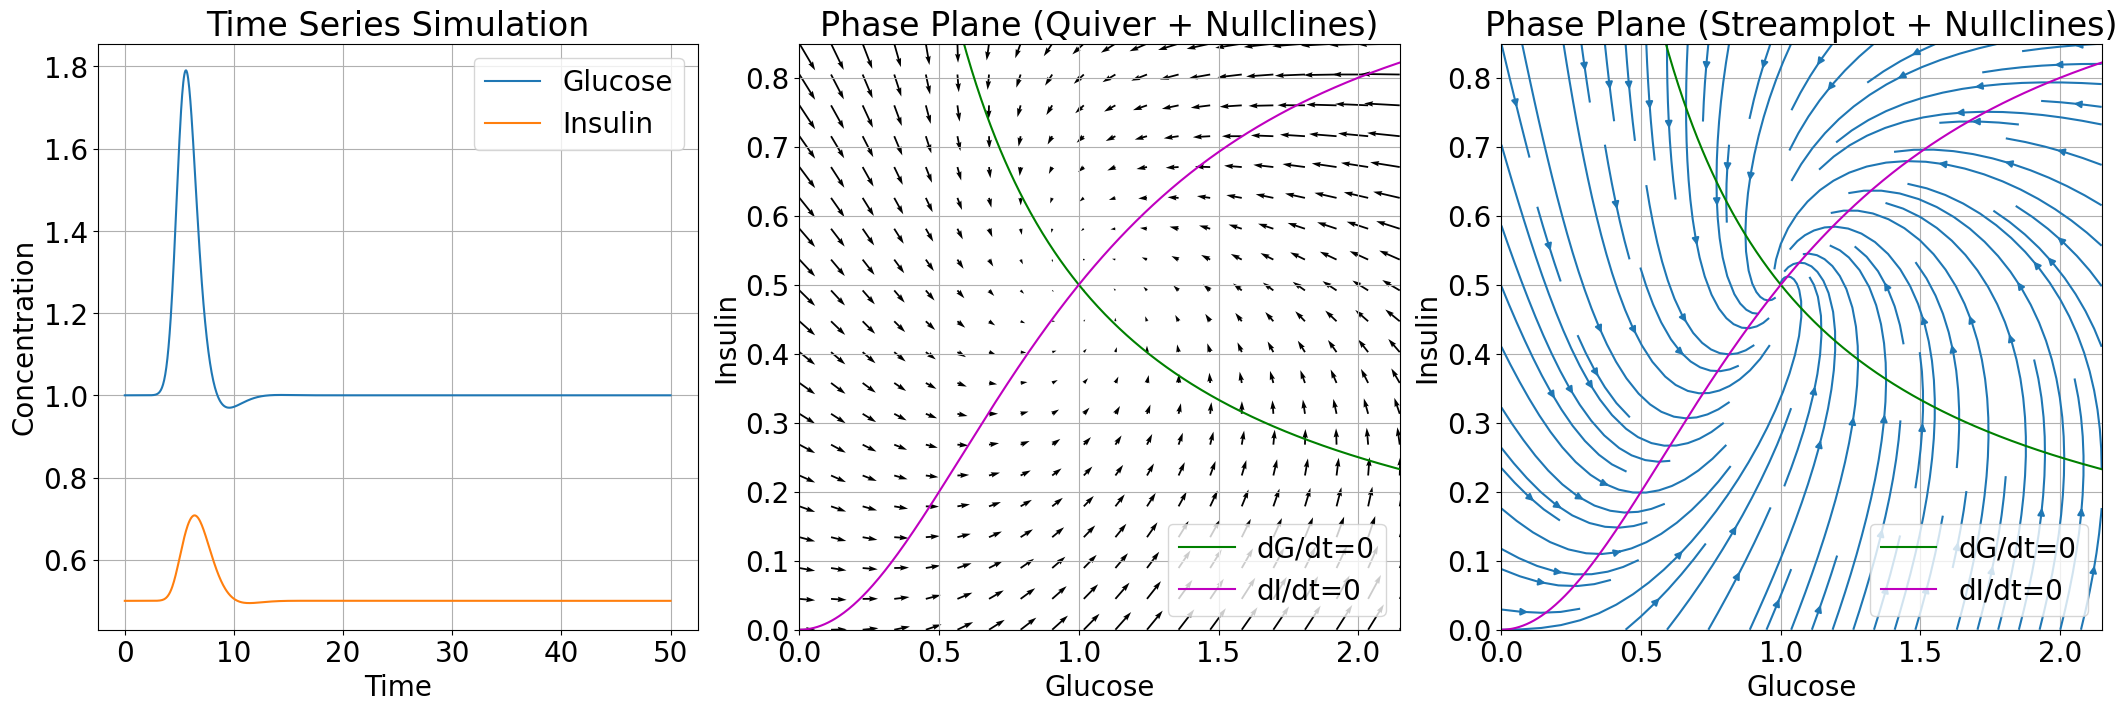

In [28]:
# Update default font size for plots (approx 2x default)
plt.rcParams.update({'font.size': 20})

# Set up the parameters
s, q, B, K, gamma = 1, 1, 1, 1, 1

# ODE function
def InsulinGlucoseSimple(t, y):
    Glucose, Insulin = y
    meal_dynamic = 0.5 + np.exp(-(t - 5)**2)
    dGlucosetdt = meal_dynamic - s * Glucose * Insulin
    dInsulindt = q * B * (Glucose**2) / (Glucose**2 + K**2) - gamma * Insulin
    return [dGlucosetdt, dInsulindt]

# Initial conditions and time span
initial_condition = [1, 0.5]
tspan = [0, 50]

# Solve ODE
soln = solve_ivp(
    InsulinGlucoseSimple, tspan, initial_condition,
    t_eval=np.linspace(tspan[0], tspan[1], 1000),
    atol=1e-10, rtol=1e-10,
)

# Initialize figure
fig, axs = plt.subplots(1, 3, figsize=(21, 7), dpi=100, constrained_layout=True)

# Plot time series
axs[0].plot(soln.t, soln.y[0], label="Glucose")
axs[0].plot(soln.t, soln.y[1], label="Insulin")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Concentration")
axs[0].set_title("Time Series Simulation")
axs[0].legend()
axs[0].grid(True)

# --- Phase Plane Analysis ---
glucose_min, glucose_max = 0, np.max(soln.y[0]) * 1.2
insulin_min, insulin_max = 0, np.max(soln.y[1]) * 1.2
glucose_range = np.linspace(glucose_min, glucose_max, 20)
insulin_range = np.linspace(insulin_min, insulin_max, 20)
G_grid, I_grid = np.meshgrid(glucose_range, insulin_range)

# Derivatives for phase portrait (using baseline meal)
const_meal = 0.5
dGdt_grid = const_meal - s * G_grid * I_grid
dIdt_grid = q * B * (G_grid**2) / (G_grid**2 + K**2) - gamma * I_grid

# Nullclines
G_null_range = np.linspace(1e-6, glucose_max, 500)
I_null_glucose = const_meal / (s * G_null_range)
I_null_insulin = (q * B / gamma) * (G_null_range**2) / (K**2 + G_null_range**2)

# Plot Quiver plot (axs[1])
axs[1].quiver(G_grid, I_grid, dGdt_grid, dIdt_grid) # Default color
axs[1].set_title("Phase Plane (Quiver + Nullclines)")

# Plot Streamplot (axs[2])
axs[2].streamplot(G_grid, I_grid, dGdt_grid, dIdt_grid) # Default color
axs[2].set_title("Phase Plane (Streamplot + Nullclines)")

for ax in axs[1:]:
    ax.plot(G_null_range, I_null_glucose, 'g', label='dG/dt=0')
    ax.plot(G_null_range, I_null_insulin, 'm', label='dI/dt=0')
    ax.set_xlabel("Glucose")
    ax.set_ylabel("Insulin")
    ax.legend()  # Corrected to use ax instead of axs[1]
    ax.set_xlim([glucose_min, glucose_max])
    ax.set_ylim([insulin_min, insulin_max])
    ax.grid(True)

plt.show()

In [12]:
# Define symbolic variables
G, I = sym.symbols('G, I') # Glucose and Insulin
m, s, q, B, K, gamma = sym.symbols('m, s, q, B, K, gamma', positive=True) # Parameters

# Define the equations for steady state (derivatives = 0)
# Assuming a constant meal input 'm' for steady state analysis
eq1 = sym.Eq(m - s * I * G, 0)
eq2 = sym.Eq(q * B * (G**2 / (K**2)) - gamma * I, 0)

# Solve the system of equations for G and I
steady_state_solutions = sym.nonlinsolve([eq1, eq2], [G, I])

# Display the solutions
print("Steady state solutions (Glucose, Insulin):")
steady_state_solutions

Steady state solutions (Glucose, Insulin):


{(K**(2/3)*gamma**(1/3)*m**(1/3)/(B**(1/3)*q**(1/3)*s**(1/3)), B**(1/3)*m**(2/3)*q**(1/3)/(K**(2/3)*gamma**(1/3)*s**(2/3))), (K**(2/3)*gamma**(1/3)*m**(1/3)*(-1 - sqrt(3)*I)/(2*B**(1/3)*q**(1/3)*s**(1/3)), -B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)) + sqrt(3)*I*B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3))), (K**(2/3)*gamma**(1/3)*m**(1/3)*(-1 + sqrt(3)*I)/(2*B**(1/3)*q**(1/3)*s**(1/3)), -B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)) - sqrt(3)*I*B**(1/3)*m**(2/3)*q**(1/3)/(2*K**(2/3)*gamma**(1/3)*s**(2/3)))}